In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
nltk.download('punkt')
nltk.download('stopwords')
#from spellchecker import SpellChecker
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
from sklearn.utils import resample
from sklearn.metrics import f1_score
from statistics import mean 
import time
import torch
import contractions
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertForSequenceClassification,AdamW,get_linear_schedule_with_warmup
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import re
from nltk.corpus import stopwords
import string
from sklearn.metrics import classification_report


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\limju\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\limju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Load train data

In [2]:
#Read in cleaned train data
train_df = pd.read_csv('train_data_with_stop.csv')
train_df = train_df.dropna(subset=['cleaned_text']).reset_index(drop=True)
#train_df['polarity_score'] = train_df['polarity_score'].astype(float)
#train_df['subjectivity_score'] = train_df['subjectivity_score'].astype(float)
train_df['stars'] = train_df['stars'].astype(float)
train_df['text'] = train_df['text'].astype(str)


train_df.head()

,idx,title,stars,text,cleaned_text
0,1,88 Seafood,5.0,This was my first time eating here. I can tell...,this be my first time eat here i can tell you ...
1,2,88 Seafood,4.0,Considering that the dining area is next to a ...,consider that the din area be next to a prawn ...
2,3,88 Seafood,4.0,1st time came was 5 months ago. A decent Cze C...,st time come be month ago a decent cze char or...
3,4,88 Seafood,5.0,"First time experiencing prawning, we spend a g...",first time experience prawn we spend a good hr...
4,5,88 Seafood,4.0,"Outgoing visit on Saturday, September 2023. Fi...",outgo visit on saturday september fishing for ...


<Axes: xlabel='stars', ylabel='count'>

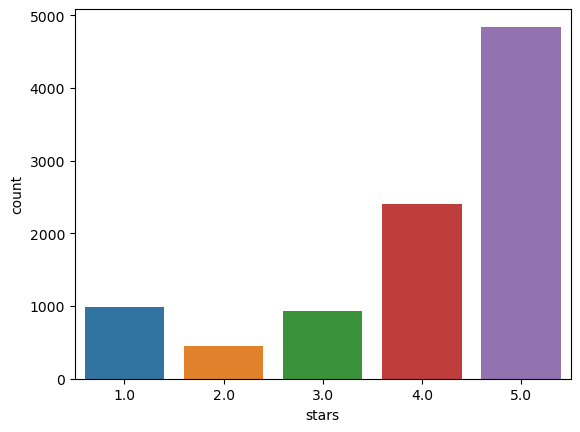

In [30]:
sns.countplot(train_df, x="stars")

### Assign polarity to train data
- Stars 4 and above, positive
-1,2,3 stars negative


In [16]:
#assign positive/negative labels method 1
train_df['sentiment'] = 0
train_df.loc[train_df['stars'] >=4, 'sentiment'] = 1 #positive

In [17]:
train_df_X = train_df['cleaned_text']
train_df_y = train_df['sentiment']

### Classification

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.version.cuda)

cuda:0
12.1


In [62]:
import gc
torch.cuda.empty_cache()
gc.collect()
del model


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Training DistilBERT

In [6]:
train_df_X, val_df_X, train_df_y, val_df_y = train_test_split(train_df_X,train_df_y, test_size=0.2, random_state=0)
print(train_df_X.shape, val_df_X.shape)

(7682,) (1921,)


In [3]:
# Define a custom dataset for sentiment analysis
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True, #[CLS], [SEP]
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }
def create_data_loader(df_X, df_y, tokenizer, max_len, batch_size):
    ds = SentimentDataset(
        texts=df_X.to_numpy(),
        labels=df_y.to_numpy(),
        tokenizer=tokenizer,
        max_length=max_len
    )
    return DataLoader(ds,batch_size=batch_size,num_workers=0)



In [8]:
# Load the pre-trained BERT model and tokenizer
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)  # 2 for binary classification

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

In [9]:
train_loader = create_data_loader(train_df_X,train_df_y, tokenizer, 512, 8)
val_loader= create_data_loader(val_df_X, val_df_y, tokenizer,512, 4)

In [10]:
# Set up the optimizer and training parameters
   
num_epochs = 6
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
loss_fn = nn.CrossEntropyLoss()
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=total_steps*0.1,
  num_training_steps=total_steps
)


trainloss=[]
trainacc=[]
trainf1=[]
valloss=[]
valacc=[]
valf1=[]

def train_step(model, num_epochs, train_loader, val_loader, loss_fn, optimizer):
    #best_accuracy=0
    best_f1=0
    best_epoch=0
    for epoch in range(num_epochs):
        runningtrainloss=0
        runningtrainacc=0
        runningtrainf1=0
        model.train() #put model in training mode
        start=time.time()
        all_ref_labels=[]
        all_pred_labels=[]
        for i, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            all_ref_labels.extend(batch['labels'].cpu().numpy())
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) #prevent exploding gradient
            optimizer.step()
            scheduler.step()
            with torch.no_grad():
                runningtrainloss+=loss.item()
                #runningtrainacc+=accuracy_score(np.argmax(outputs['logits'].detach().cpu().numpy(), axis=1), labels.detach().cpu().numpy())
                all_pred_labels.extend(np.argmax(outputs['logits'].detach().cpu().numpy(), axis=1))
                if i%1000==0:
                    print(f"Iteration {i}, trainloss = {loss.item()}")
        
        trainloss.append(runningtrainloss/(i+1))
        #trainacc.append(runningtrainacc/(i+1))
        trainf1.append(f1_score(all_ref_labels, all_pred_labels, average='macro'))
        end=time.time()
        model.eval() #put model in eval mode
        with torch.no_grad():
            runningvalloss=0
            #runningvalacc=0
            all_ref_labels=[]
            all_pred_labels=[]
            for i, batch in enumerate(val_loader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                all_ref_labels.extend(batch['labels'].cpu().numpy())

                # Get model ouptuts
                outputs = model(input_ids=input_ids,attention_mask=attention_mask, labels=labels)
                
                runningvalloss+=outputs.loss.item()
                #runningvalacc+=accuracy_score(np.argmax(outputs['logits'].detach().cpu().numpy(), axis=1), labels.detach().cpu().numpy())
                all_pred_labels.extend(np.argmax(outputs['logits'].detach().cpu().numpy(), axis=1))

            epvalf1= f1_score(all_ref_labels, all_pred_labels, average='macro')


            valloss.append(runningvalloss/(i+1))
            valf1.append(epvalf1)
            if valf1[-1]>best_f1:
                #model.save_pretrained(f'C:/Users/limju/Downloads/IR_BERTTraining/BERT_best_epoch_{epoch}')

                #tokenizer.save_pretrained(f'C:/Users/limju/Downloads/IR_BERTTraining/Tokenizer_best_epoch_{epoch}')
                best_epoch=epoch
        model.save_pretrained(f'C:/Users/limju/Downloads/IR_BERTTraining/BERT_epoch_{epoch}')
        tokenizer.save_pretrained(f"C:/Users/limju/Downloads/IR_BERTTraining/Tokenizer_epoch_{epoch}")
        print(f"Time for 1 epoch: {end-start}")
        print(f"End of Epoch {epoch+1}, trainloss={runningtrainloss/(i+1)}, valloss={runningvalloss/(i+1)} trainf1={trainf1[-1]}, valf1={epvalf1}")
    return best_epoch, trainloss,trainacc,valloss,valacc

best_epoch, trainloss,trainacc,valloss,valacc = train_step(model, num_epochs, train_loader, val_loader, loss_fn, optimizer)

c:\Users\limju\anaconda3\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Iteration 0, trainloss = 0.7001364231109619
Time for 1 epoch: 258.4634644985199
End of Epoch 1, trainloss=0.6442394805142729, valloss=0.4321166046366498 trainf1=0.8302871060680979, valf1=0.8382288972879783
Iteration 0, trainloss = 0.3494257926940918
Time for 1 epoch: 256.1168715953827
End of Epoch 2, trainloss=0.4012371032068452, valloss=0.41189160873327335 trainf1=0.9188414820532831, valf1=0.8702152565612431
Iteration 0, trainloss = 0.026891279965639114
Time for 1 epoch: 259.2119243144989
End of Epoch 3, trainloss=0.24086097047144833, valloss=0.45831906059495486 trainf1=0.9604786405964559, valf1=0.8766745282413222
Iteration 0, trainloss = 0.0018441793508827686
Time for 1 epoch: 255.6474528312683
End of Epoch 4, trainloss=0.13094951583428566, valloss=0.5781859224675496 trainf1=0.9804557925115771, valf1=0.8726295780596744
Iteration 0, trainloss = 0.00045007053995504975
Time for 1 epoch: 254.95154356956482
End of Epoch 5, trainloss=0.08589878581311088, valloss=0.6232886644776534 trainf1=

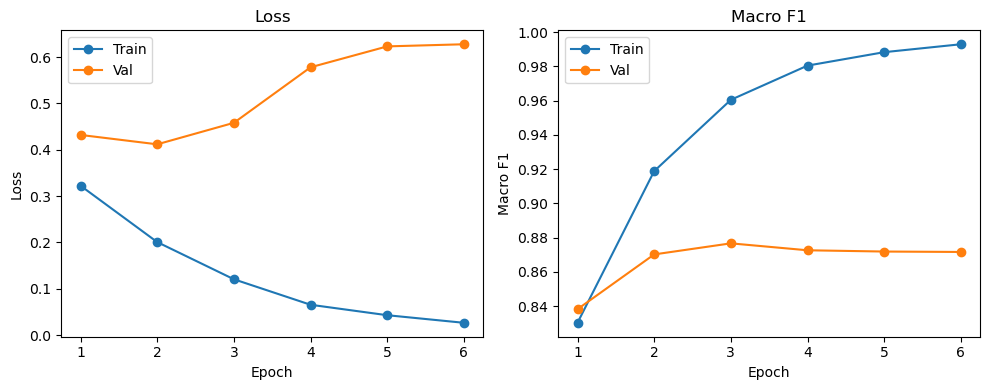

In [15]:
import matplotlib.pyplot as plt
epochs = [1, 2, 3, 4,5,6]  # List of epoch numbers

# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, trainloss, marker='o', linestyle='-', label='Train')
plt.plot(epochs, valloss, marker='o', linestyle='-', label='Val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot macro f1
plt.subplot(1, 2, 2)
plt.plot(epochs, trainf1, marker='o', linestyle='-',label='Train')
plt.plot(epochs, valf1, marker='o', linestyle='-', label='Val')
plt.title('Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')

# Display the plots
plt.legend()
plt.tight_layout()
plt.show()

### Testing DistilBERT on test split

In [5]:
# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def remove_stopwords(reviews):
    STOPWORDS = set(stopwords.words('english'))
    custom_stopwords = {'not', 'is', 'but'}
    STOPWORDS -= custom_stopwords
    if STOPWORDS is None:
        STOPWORDS = set(stopwords.words('english'))
    # Split the reviews into words and remove stopwords
    words = reviews.split()
    words_filtered = [word for word in words if word not in STOPWORDS]
    
    # Join the filtered words back into a string
    filtered_reviews = ' '.join(words_filtered)
    
    return filtered_reviews

def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:]

def lower_case(review):
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
    
    new_review = review.translate(str.maketrans('', '', string.punctuation))
    return new_review

# Remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review


def clean_text(data):

    data = data.apply(lower_case)
    data = data.apply(change_contractions)
    data = data.apply(remove_emojis)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_numbers)
    data = data.apply(remove_stopwords)
    data = data.apply(remove_extra_whitespace)
    data = data.apply(lemmaSentence)
    
    return data

def clean_text_withstopword(data):

    data = data.apply(lower_case)
    data = data.apply(change_contractions)
    data = data.apply(remove_emojis)
    data = data.apply(remove_punctuations)
    data = data.apply(remove_numbers)
    #data = data.apply(remove_stopwords)
    data = data.apply(remove_extra_whitespace)
    data = data.apply(lemmaSentence)
    
    return data

In [5]:
#Load in test data
testdf = pd.read_csv("eval.csv")
#preprocess test data
testdf['cleaned_text'] = clean_text(testdf.text)
def anno2binary(text):
    if text=='POSITIVE':
        return 1
    else:
        return 0
testdf['Binary_anno'] = testdf.Polarity_Anno1.apply(anno2binary)

In [6]:
# Load the trained BERT model and tokenizer
tokenizer_name = r'C:\Users\limju\Downloads\IR_BERTTraining\Tokenizer_epoch_3'
model_name = r'C:\Users\limju\Downloads\IR_BERTTraining\BERT_epoch_3'
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, use_fast=True)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)  # 2 for binary classification

In [20]:
test_loader= create_data_loader(testdf.cleaned_text, testdf.Binary_anno, tokenizer,512, 4)

In [7]:
def evaluate(model, val_loader, device):
    model.eval() #put model in eval mode
    with torch.no_grad():
        all_ref_labels=[]
        all_pred_labels=[]
        start=time.time()

        for i, batch in enumerate(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            all_ref_labels.extend(batch['labels'].cpu().numpy())

            # Get model ouptuts
            outputs = model(input_ids=input_ids,attention_mask=attention_mask, labels=labels)
            
            all_pred_labels.extend(np.argmax(outputs['logits'].detach().cpu().numpy(), axis=1))

            del input_ids, attention_mask, labels
        end = time.time()
    t = end-start
    return all_ref_labels,all_pred_labels,t

In [21]:
all_ref_labels,all_pred_labels,t = evaluate(model, test_loader, device)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
print(classification_report(all_ref_labels, all_pred_labels))

              precision    recall  f1-score   support

           0       0.73      0.89      0.80       220
           1       0.97      0.91      0.94       848

    accuracy                           0.91      1068
   macro avg       0.85      0.90      0.87      1068
weighted avg       0.92      0.91      0.91      1068



In [35]:
t

12.186556577682495

### Inference on entire dataset

In [32]:
import json
 
# Opening JSON file
f = open('docs_to_post.json')
 
# returns JSON object as 
# a dictionary
data = json.load(f)
 

# Closing file
f.close()

In [9]:
data.keys()

dict_keys(['restaurant', 'review_stars', 'review', 'publishedAtDate', 'likesCount', 'reviewer', 'reviewerNumberOfReviews', 'isLocalGuide', 'reviewContextMeal', 'reviewContextParking', 'reviewContextService', 'reviewDetailedRatingAtmosphere', 'reviewDetailedRatingFood', 'reviewDetailedRatingService', 'totalScore', 'reviewsCount', 'street', 'categoryName', 'address', 'neighborhood', 'LatLong', 'qualityScore'])

In [9]:
all_reviews = []
for i in data['review']:
    all_reviews.append(data['review'][i])
all_reviews_series = pd.Series(all_reviews) 
all_reviews_series = clean_text(all_reviews_series)

In [11]:
data['review_stars']
stars=[]
for i in data['review_stars']:
    stars.append(data['review_stars'][i])
stars = pd.Series(stars)
stars2= stars.copy()
stars.loc[stars2 <4]=0
stars.loc[stars2 >=4] = 1 #positive

In [12]:
all_loader= create_data_loader(all_reviews_series, stars, tokenizer,512,2)

In [13]:
all_ref_labels,all_pred_labels,t = evaluate(model, all_loader, device)

In [28]:
all_pred_labels = [ int(x) for x in all_pred_labels ]

In [29]:
res_dict = {}
for i, pred in enumerate(all_pred_labels):
    res_dict[i]=pred

In [30]:
data['classPrediction'] = res_dict

In [31]:
with open("updated_docs_to_post.json", "w") as outfile: 
    json.dump(data, outfile)

In [39]:
df = pd.read_csv("final_cleaned_reviews_J.csv")

C:\Users\limju\AppData\Local\Temp\ipykernel_16908\755542211.py:1: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("final_cleaned_reviews_J.csv")


In [41]:
df['classPrediction']= all_pred_labels

In [43]:
df.to_csv("all_reviews_with_pred.csv")